# Imports

In [22]:
# read files
import json
import urllib.request 
import re, os
import sys

# preprocessing, math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# helper functions
from helperFunctions import *

# naive bayes
from naiveBayes import *

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# Load dataset

In [23]:
# Source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
dataset = 'True.csv' # Fake.csv
df = pd.read_csv('dataset/' + dataset)

In [24]:
# Merge all textual input, discard the rest (except for the labels)
df.text = df.title + ' ' + df.text
df.rename(columns={'subject': 'label'},
          inplace=True, errors='raise')
df.drop(['title', 'date'], axis=1, errors='ignore', inplace=True)

In [25]:
df.shape

(21417, 2)

# Analyse and Preprocess

missing labels?

In [26]:
df.isnull().sum()

text     0
label    0
dtype: int64

classes

In [27]:
df.label.unique()

array(['politicsNews', 'worldnews'], dtype=object)

is the dataset balanced?

(<AxesSubplot:>,
 politicsNews    11272
 worldnews       10145
 Name: label, dtype: int64)

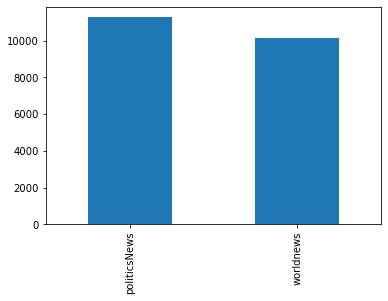

In [28]:
counts = df['label'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar'), counts

Numeric Labels

In [29]:
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


Clean text, remove symbols and stopwords

In [30]:
# this needs alot of cpu AND ram resources
#df['text'] = df['text'].apply(cleanNLFeature)
df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [31]:
#df.to_csv('dataset_preprocessed-' + dataset, sep='\t', index=False)

In [32]:
df = pd.read_csv('dataset_preprocessed-' + dataset, sep='\t')

Create train, validation, test split

In [33]:
# train val test relation -> 60:20:20
trainval, test = train_test_split(df, test_size=0.2, random_state=12345)
train, val = train_test_split(trainval, test_size=0.25, random_state=12345)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
train.head()

,text,label
0,exclusive pentagon lockheed near deal billion ...,0
1,france says saudi coalition must boost aid eff...,1
2,u.s. renews call cambodia release opposition l...,1
3,treasury 's mnuchin trump 's proposed corporat...,0
4,romanian ruling party leader investigated 'cri...,1


In [34]:
train.shape, val.shape, test.shape

((12849, 2), (4284, 2), (4284, 2))

Create Frequency Table

In [35]:
# ~cubic complexity, very time consuming
#freq_tb, uniques = frequencyTable(train)

In [36]:
#np.save('freq_tb-' + dataset, freq_tb)
#np.save('uniques-' + dataset, uniques)

In [37]:
with open('freq_tb-' + dataset + '.npy', 'rb') as f:
    freq_tb = np.load(f)
with open('uniques-' + dataset + '.npy', 'rb') as f:
    uniques = np.load(f).tolist()

In [38]:
freq_tb, len(uniques)

(array([[102.,  53.],
        [405., 116.],
        [113.,  20.],
        ...,
        [  1.,   0.],
        [  1.,   0.],
        [  1.,   0.]]),
 71910)

Create likelyhood table

In [39]:
# no need to merge all information into one table
sumRowsRel, sumColsRel = likelihoodTable(freq_tb)  

# Apply Naive Bayes

prep validation set

In [40]:
y_val = val.label
val.drop('label', axis=1, inplace=True, errors='ignore')

run prediction for the validation set

In [41]:
y_val.nunique()

2

In [42]:
""" y_pred = []
for d in val.text:
    y_pred.append(predictDoc(d, uniques, freq_tb, sumRowsRel, sumColsRel)) """

In [43]:
""" df_results = pd.DataFrame(val.text) #, 'label':y_val, 'prediction':y_pred
df_results['label'] = y_val
df_results['prediction'] = y_pred
df_results['TP'] = df_results.label == df_results.prediction
df_results.head() """

,text,label,prediction,TP
0,yemen humanitarian situation likely worsen sal...,1,1,True
1,erdogan says turkey iran russia agreed carry p...,1,1,True
2,republican ryan raising big money white house ...,0,1,False
3,mexican president asks senate broaden discussi...,1,1,True
4,uk government official says 'does recognize re...,1,1,True


presist

In [44]:
#df_results.to_csv('naive-bayes-results-' + dataset, sep='\t', index=False)
df_results = pd.read_csv('naive-bayes-results-' + dataset, sep='\t')

# Evaluate prediction

In [45]:
# use weighted accuracy, since the dataset is unbalanced
val_sample_weights = class_weight.compute_sample_weight('balanced', y_val._values)

baseline - just guess one out of five classes -> 20% weighted accuracy

In [46]:
baseline_weighted_accuracy = accuracy_score(df_results.label, [0 for l in df_results.label], 
                                           sample_weight=val_sample_weights)

print('baseline_weighted_accuracy=%.3f' %baseline_weighted_accuracy)


baseline_weighted_accuracy=0.500


prediction

In [47]:
counts = df_results.TP.value_counts()
acc = counts[1]/counts.sum()
print('accuracy:', acc)

accuracy: 0.7714752567693745


Weighted accuracy because the dataset is unbalanced as shown above

In [48]:
sklearn_weighted_accuracy = accuracy_score(df_results.label, df_results.prediction, 
                                           sample_weight=val_sample_weights)

print('sklearn_weighted_accuracy=%.3f' %sklearn_weighted_accuracy)

sklearn_weighted_accuracy=0.780
